# Swissroll Example

This notebook explores DiffusionEMD on a the swissroll dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import phate
import scprep
import sklearn
from sklearn.neighbors import kneighbors_graph

from DiffusionEMD import (
    DiffusionCheb,
    DiffusionTree,
    MetricTree,
)
from DiffusionEMD import dataset

### Build Dataset
We build a swiss roll dataset with `n_distributions` gaussians centered along the swiss roll with `n_points_per_distribution` points sampled from each one. This data is rotated randomly in some number of dimensions (here 3) which allows us to explore what happens when the swiss roll is not axis aligned.


In [2]:
%%time
n_neighbors=10
n_distributions=1000
n_points_per_distribution=10

ds = dataset.SwissRoll(width=10, 
                       manifold_noise=2,
                       n_distributions=n_distributions, 
                       n_points_per_distribution=n_points_per_distribution
     )
ds.X = ds.rotate_to_dim(3)
G = ds.get_graph()
X_std = ds.standardize_data()

CPU times: user 11.8 s, sys: 40.1 ms, total: 11.8 s
Wall time: 500 ms


### Helper functions

Here we define some helper functions to compute a nearest neighbors graph between distributions using various methods either using Trees or DiffusionEMD.

In [3]:
def tree_runner(tree_type, n_trees, **kwargs):
    embeds = []
    for i in range(n_trees):
        mt = MetricTree(tree_type=tree_type, **kwargs)
        counts, edge_weights = mt.fit_transform(
            X=ds.std_X if tree_type == "quad" else ds.X, y=ds.labels,
        )
        embeds.extend(l1_embeddings(counts.todense(), edge_weights).T)
    embeds = np.array(embeds).T
    A = kneighbors_graph(
        embeds, n_neighbors=n_neighbors+1, metric="l1", include_self=True, n_jobs=-1
    )
    return embeds, A


def demd_runner(**kwargs):
    dc = DiffusionCheb(**kwargs)
    embeds = dc.fit_transform(G.W, ds.labels)
    A = kneighbors_graph(
        embeds, n_neighbors=n_neighbors+1, metric="l1", include_self=True, n_jobs=-1
    )
    return embeds, A


def l1_embeddings(cts, edge_weights):
    return np.array(
        [np.asarray(cts)[i, :] * np.asarray(edge_weights) for i in range(len(cts))]
    )

### Run methods

We compute embeddings for each method and the nearest neighbors, parameters can be adjusted for each method.

In [4]:
%%time
e_q, A_q = tree_runner("quad", 150, n_levels=4)

CPU times: user 7min 51s, sys: 6.49 s, total: 7min 57s
Wall time: 23 s


In [5]:
%%time
e_c, A_c = tree_runner("cluster", 150, n_levels=4, n_clusters=4)

CPU times: user 3min 49s, sys: 4.04 s, total: 3min 53s
Wall time: 55.3 s


In [6]:
%%time
e_d, A_d = demd_runner(max_scale=10, delta=1e-5)

CPU times: user 8min 19s, sys: 19 s, total: 8min 38s
Wall time: 24.2 s


### Display embeddings

Next we show the embeddings of the nearest neighbors graphs between distributions, with the idea that all methods should preserve the manifold structure between distributions. We embed using PHATE, and color by the two axes of the manifold. These two axes should be distinct in the embedding.

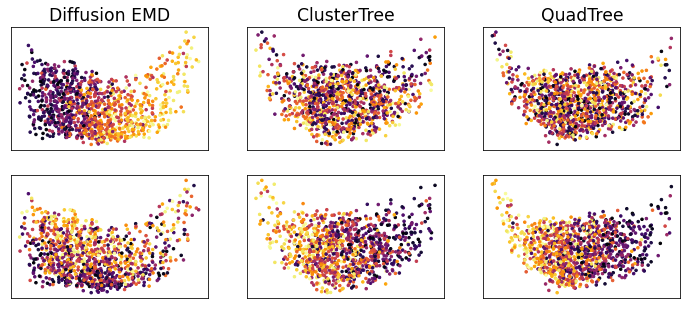

In [7]:
As = [A_d, A_c, A_q]
names = ["Diffusion EMD", "ClusterTree", "QuadTree"]
embeds = []
for AA, name in zip(As, names):
    phate_op = phate.PHATE(
        knn_dist="precomputed_affinity", n_jobs=-1, n_components=2, t=5, verbose=False
    )
    phate_coords = phate_op.fit_transform(AA)
    embeds.append(phate_coords)

fig, axes = plt.subplots(2, 3, figsize=(12, 5))
axes = axes.flatten()
i = 0
for color in [ds.t, ds.means[:, 1]]:
    for e, name in zip(embeds, names):
        scprep.plot.scatter2d(
            e,
            title="%s" % name if i < 3 else "",
            c=color,
            ticks=[],
            colorbar=False,
            ax=axes[i],
        )
        i += 1